## 載入一些套件
- 基本上是使用keras，部分沒有內建的就用keras提供的backend+lambda處理
- Data 用 Mnist 手寫資料集
- 下面的 Code 是根據 https://gist.github.com/mmmikael/0a3d4fae965bdbec1f9d 改的
- 主要修改的部分，為版本過舊而不支援的問題、loss funtion定義、base_network的定義等

In [9]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import random
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

## 定義一些接下來會用到的function
- euclidean_distance計算歐式距離
- eucl_dist_output_shape，轉換euclidean_distance輸出的tensor shape，輸入lambda層用的
- contrastive_loss 剛剛提到的第一種loss
- create_pairs把mnist的data分成pairs，並且確保相似的與不相似的pair data的數量是一致的

In [18]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

## Data Processing
- 同除255做normalize
- created pairs

In [11]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_image = X_train
X_test_image = X_test
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
input_shape = (28,28,1)
nb_epoch = 10
num_classes = 1
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

## 建立siamese_network

In [12]:
def create_base_network(input_shape):
    model = Sequential()  
    model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=36,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Dropout(0.25))  
    model.add(Flatten()) 
    model.add(Dense(128, activation='relu'))  
    return model

In [13]:
base_network = create_base_network(input_shape)

In [14]:
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [15]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=128,
          epochs=nb_epoch)

Train on 108400 samples, validate on 17820 samples
Epoch 1/10
108400/108400 [==============================] - 142s - loss: 0.0621 - val_loss: 0.0272
Epoch 2/10
108400/108400 [==============================] - 142s - loss: 0.0293 - val_loss: 0.0217
Epoch 3/10
108400/108400 [==============================] - 143s - loss: 0.0232 - val_loss: 0.0174
Epoch 4/10
108400/108400 [==============================] - 143s - loss: 0.0204 - val_loss: 0.0162
Epoch 5/10
108400/108400 [==============================] - 139s - loss: 0.0186 - val_loss: 0.0159
Epoch 6/10
108400/108400 [==============================] - 137s - loss: 0.0174 - val_loss: 0.0155
Epoch 7/10
108400/108400 [==============================] - 137s - loss: 0.0164 - val_loss: 0.0152
Epoch 8/10
108400/108400 [==============================] - 137s - loss: 0.0156 - val_loss: 0.0144
Epoch 9/10
108400/108400 [==============================] - 137s - loss: 0.0150 - val_loss: 0.0142
Epoch 10/10
108400/108400 [==============================]

In [7]:
from keras.models import load_model
model = load_model('my_model.h5', custom_objects={'contrastive_loss': contrastive_loss})

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.6/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## 定義accuracy function

In [23]:
def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() > 0.5].mean()

# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.05%
* Accuracy on test set: 97.91%


## Show結果用的function

In [19]:
def showpre(img_num1,img_num2):
    predtest =  model.predict([X_test[img_num1:img_num1+1],X_test[img_num2:img_num2+1]])
    print(predtest)
    if(predtest<0.5):
        print('true')
    else:
        print('false')
    plt.subplot(121),plt.imshow(X_test_image[img_num1], cmap='gray'),plt.title(img_num1)
    plt.subplot(122),plt.imshow(X_test_image[img_num2], cmap='gray'),plt.title(img_num2)
    plt.show()

In [12]:
for idx, val in enumerate(y_test):
    if(val == 5):
        print(idx)

8
15
23
45
52
53
59
102
120
127
129
132
152
153
155
162
165
167
182
187
207
211
218
219
240
253
261
283
289
317
319
333
340
347
351
352
356
364
367
375
395
397
406
412
433
460
469
478
483
491
502
509
518
540
570
588
604
618
638
645
654
674
692
694
710
711
720
739
751
766
778
779
785
791
797
812
856
857
866
869
897
934
935
951
955
970
978
1003
1022
1032
1041
1046
1070
1073
1082
1087
1089
1102
1113
1115
1131
1135
1144
1146
1168
1169
1190
1221
1233
1235
1243
1252
1258
1272
1281
1285
1289
1299
1331
1334
1339
1340
1370
1376
1378
1393
1405
1406
1421
1447
1460
1466
1467
1471
1473
1476
1493
1510
1521
1525
1550
1598
1618
1629
1635
1637
1639
1641
1653
1670
1672
1677
1684
1693
1737
1747
1752
1755
1761
1810
1833
1846
1847
1860
1866
1874
1879
1896
1902
1910
1911
1917
1931
1940
1948
1954
1967
1970
1999
2001
2003
2021
2029
2030
2035
2037
2040
2064
2073
2077
2078
2100
2103
2113
2114
2125
2134
2159
2162
2180
2192
2207
2214
2224
2237
2241
2247
2279
2282
2291
2322
2339
2346
2369
2400
2413
2445
2452
2460


[[0.0172571]]
true


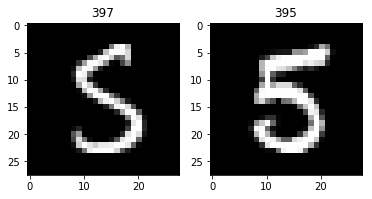

In [22]:
showpre(397,395)

## save model

In [16]:
model.save('my_model.h5')